# Trabalho Prático 2: Descritores de Características
### Jorge Augusto de Lima e Silva
### Universidade Federal de Minas Gerais - 2022/2
### Disciplina: Introdução à Computação Visual
### Professor: William Robson Schwartz

## Imports de bibliotecas importantes

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

## Parte 1: HOG
A primeira parte do trabalho consiste na implementação do método Histogram of Oriented Gradients e seu uso para a extração do vetor de features das imagens a serem testadas.

### Implementação do HOG:
A implementação consiste em:
1. Primeiro redimensionar a imagem, de modo que esta passe a ter 32x32 píxeis
2. Encontrar os gradientes da imagem, feito pela chamada da função findGradient(img)
3. Passar a janela flutuante com o tamanho do bloco pela imagem
4. Computar o vetor de features de cada bloco
5. Concatenar os vetores de features encontrados formando assim um único vetor de features

In [2]:
def HOGImage(image, w, h, s):
    # redimensiona a imagem para o tamanho 32x32
    img = cv2.resize(image, (32,32))
    
    # encontra os gradientes, representados através de coordenadas polares
    mag, angle = findGradient(img)
    
    # inicializa o vetor onde as features finais das imagens ficarão armazenadas
    features = np.zeros(0)
    
    for i in range(0, img.shape[0], s):
        for j in range(0, img.shape[1], s):
            blockFeatures = computeHOG(mag[i:i+w,j:j+h],angle[i:i+w,j:j+h], w, h)
            features = np.concatenate((features, blockFeatures),axis=None)
    
    return features

### Os Gradiente da Imagem:
Encontrar o gradiente consiste em passar dois filtros na imagem, com as seguintes máscaras:

1. $$\begin{bmatrix} -1 & 0 & 1 \end{bmatrix}$$ sendo esta referente à derivada parcial no eixo x: $g_x$;
2. $$\begin{bmatrix} -1 \\ 0 \\ 1 \end{bmatrix}$$ sendo esta referente à derivada parcial no eixo y: $g_y$.

Sabendo que o gradiente é um vetor de derivadas parciais, podemos calcular sua magnitude através da função:

<center>$||g||_2=\sqrt{||g_x||_2^2+||g_y||_2^2}$, <center>

e seu ângulo usando: 

<center>$\theta = \arctan{\frac{g_x}{g_y}}$.<center>

O ângulo em seguida é convertido de radianos para graus e apenas seu mod 180 é considerado.
Por fim, o ângulo é dividido por 20, para facilitar na hora de encaixá-lo nos bins do HOG.

In [3]:
def findGradient(img):
    # padding para aplicação do filtro que encontra derivadas parciais
    aux = np.zeros((34,34))
    aux[0,1:33] = img[0,:]
    aux[33,1:33] = img[31,:]
    aux[1:33,0] = img[:,0]
    aux[1:33,33] = img[:,31]
    aux[1:33,1:33] = img

    # aplica filtro que encontra derivada parcial no eixo x, com base na máscara -[1,0,1]
    gx = np.zeros((32,32))
    for i in range(32):
        for j in range(32):
            gx[i,j] = aux[i+1,j+2] - aux[i+1,j]
            
    # aplica filtro que encontra a dericada parcial no eixo y, com base na máscara [-1,0,1] transposta
    gy = np.zeros((32,32))
    for i in range(32):
        for j in range(32):
            gy[i,j] = aux[i+2,j+1] - aux[i,j+1]
            
    # encontra magnitude dos gradientes
    mag = np.sqrt(gx**2 + gy**2)
    
    # encontra o ângulo dos gradientes
    angle = np.arctan(gy/(gx+10**(-100)))
    angle = np.rad2deg(angle)
    
    # considera apenas o módulo dos gradientes, não o sentido para onde estão virados
    angle = angle % 180
    
    # realiza essa divisão para facilitar encaixar nos 9 bins do HOG
    angle = angle / 20
    
    return mag, angle

### O Cálculo do Vetor de Features de uma Célula:
Sabemos que temos 9 bins, portanto, um vetor de 9 posições é criado.

Sabemos também que os valores que os ângulos podem assumir pertencem ao intervalo \[0,9).

Em seguida, os gradientes da imagem são percorridos e colocados da seguinte forma:
1. A parte inteira do ângulo dita a quais dois bins a magnitude do gradiente será dividida;
2. A parte decimal do ângulo dita como essa divisão será feita:
3. Quando menor a parte deciaml, maior a fração do gradiente que vai para o bin indexado pela parte inteira.
4. O resto do que foi usado no passo anterior é destinado para o próximo bin.

In [4]:
def cellFeatures(mag, angle):
    # declara o vetor de features onde os dados serão escritos
    features = np.zeros(9, dtype=np.float32)
    
    # itera pelos gradientes escrevendo-os no vetor de features
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            # divide a maginitude do gradiente entre dois bins de acordo com o quão no meio dos dois ele está
            if(angle[i,j] > 8):
                features[8] += mag[i,j]*(1-(angle[i,j]%1))
                features[0] += mag[i,j]*(angle[i,j]%1)
            else:
                features[int(angle[i,j])] += mag[i,j]*(1-(angle[i,j]%1))
                features[int(angle[i,j])+1] += mag[i,j]*(angle[i,j]%1)
                
    return features

### O Vetor de Features de um Bloco:
Inicialmente concatenamos os vetores de features das 4 células que compõe um bloco.

Agora com um vetor de 36 posições, este é normalizado, transformando-se em um vetor unitário, a partir da seguinte operação:

<center>$v = \frac{v}{||v||_2}$<center>

In [5]:
def computeHOG(mag, angle, w, h):
    # calcula os histogramas de gradientes para cada uma das  células de um bloco
    topRightCell = cellFeatures(mag[:int(w/2),:int(h/2)],angle[:int(w/2),:int(h/2)])
    topLeftCell = cellFeatures(mag[:int(w/2),int(h/2):],angle[:int(w/2),int(h/2):])
    bottonRightCell = cellFeatures(mag[int(w/2):,:int(h/2)],angle[int(w/2):,:int(h/2)])
    bottonLeftCell = cellFeatures(mag[int(w/2):,int(h/2):],angle[int(w/2):,int(h/2):])
    
    # concatena os quatro histogramas em um só
    features = np.concatenate((topRightCell, topLeftCell, bottonRightCell, bottonLeftCell), axis=None)
    
    # normaliza o histograma de modo que este represente um vetor unitário
    features = features/(np.sqrt((features**2).sum())+10**(-10))
    
    # retorno o vetor de features encontrado
    return features

### HOG na Base de Dados Fornecida:
Agora com o HOG implementado, este é testado na base de dados fornecida.

As células abaixo são responsáveis por abrir as imagens de cada uma das classes, obter seus vetores de características e inserí-los na matriz que armazenas os vetores de características.

In [6]:
img = cv2.imread('Sandal/000.png', 0)
samples = HOGImage(img,16,16,8).reshape(1,576)
for i in range(1,100):
    i = str(i).zfill(3)
    img = cv2.imread('Sandal/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [7]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Pullover/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [8]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Trouser/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [9]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread("Ankle Boot/"+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [10]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Bag/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [11]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Coat/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [12]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Dress/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [13]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Shirt/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [14]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('Sneaker/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

In [15]:
for i in range(0,100):
    i = str(i).zfill(3)
    img = cv2.imread('T-shirt/'+i+'.png', 0)
    samples = np.concatenate((samples, HOGImage(img,16,16,8).reshape(1,576)), axis=0)

## Redução de Dimensionalidade para apenas 3 clases

In [16]:
partial_results = TSNE().fit_transform(samples[:300,:])

/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


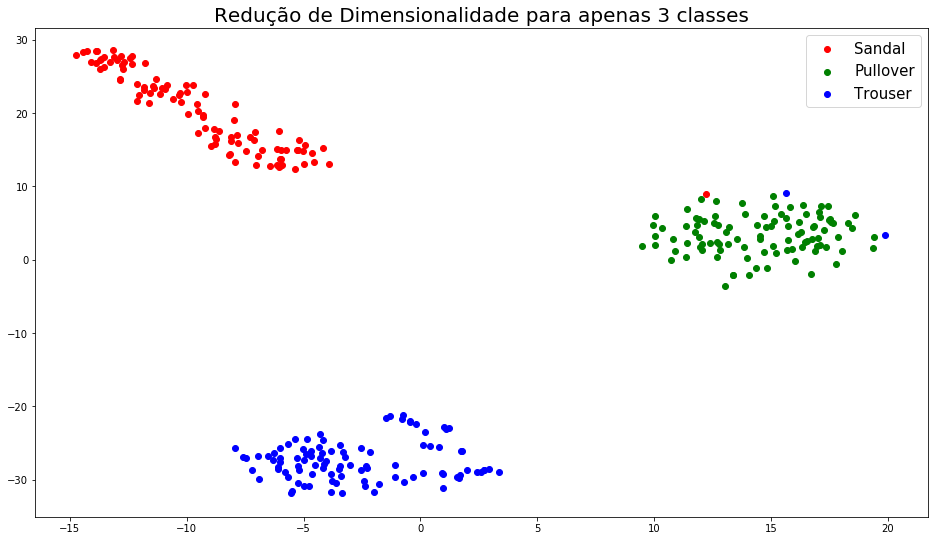

In [17]:
plt.figure(figsize=(16,9))
plt.scatter(x=partial_results[:100,0],y=partial_results[:100,1],color='r',label='Sandal')
plt.scatter(x=partial_results[100:200,0],y=partial_results[100:200,1],color='g',label='Pullover')
plt.scatter(x=partial_results[200:,0],y=partial_results[200:,1],color='b',label='Trouser')
plt.legend(prop={'size': 15})
plt.title("Redução de Dimensionalidade para apenas 3 classes", fontdict={'fontsize': 20})
plt.show()

### Conlusão do método para apenas 3 classes:
O método teve um resultado muito bom quando foi feito para apenas 3 classes, conseguindo gerar clusters que diferenciam claramente Sandals, Pullovers e Trousers. Ouveram dois membros de Trouser e um de Sandal que ficaram classificados como Pullover, mas considerando a quantidade de amostras que temos, esse erro não é algo grande o suficiente para invalidar os resultados positivos obtidos pelo método.

## Redução de Dimensionalidade para todas as 10 classes

In [18]:
results = TSNE().fit_transform(samples)

/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


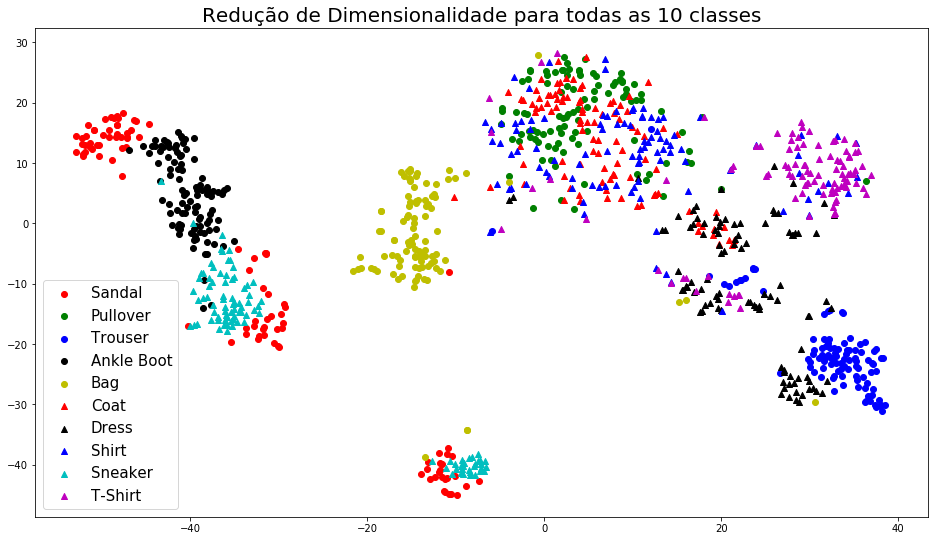

In [19]:
plt.figure(figsize=(16,9))
plt.scatter(x=results[:100,0],y=results[:100,1],color='r',label='Sandal')
plt.scatter(x=results[100:200,0],y=results[100:200,1],color='g',label='Pullover')
plt.scatter(x=results[200:300,0],y=results[200:300,1],color='b',label='Trouser')
plt.scatter(x=results[300:400,0],y=results[300:400,1],color='k',label='Ankle Boot')
plt.scatter(x=results[400:500,0],y=results[400:500,1],color='y',label='Bag')
plt.scatter(x=results[500:600,0],y=results[500:600,1],color='r',marker='^',label='Coat')
plt.scatter(x=results[600:700,0],y=results[600:700,1],color='k',marker='^',label='Dress')
plt.scatter(x=results[700:800,0],y=results[700:800,1],color='b',marker='^',label='Shirt')
plt.scatter(x=results[800:900,0],y=results[800:900,1],color='c',marker='^',label='Sneaker')
plt.scatter(x=results[900:,0],y=results[900:,1],color='m',marker='^',label='T-Shirt')
plt.legend(prop={'size': 15})
plt.title("Redução de Dimensionalidade para todas as 10 classes", fontdict={'fontsize': 20})
plt.show()

### Conclusão do método para todas as 10 classes:
Diferente do resultado apresentado para apenas 3 classes, já existe uma confusão maior quando estamos tentando diferenciar mais classes. Enquanto temos algumas classes em quais seus elementos ficaram próximos entre si, como T-Shirt e Bag, temos outras nas quais seus elementos foram dispersos entra várias classes, como Dress e Sandal. O método, por desconsiderar a posição no espaço onde os gradientes estão posicionados, tem certa dificuldade em diferenciar objetos que tem uma silhueta parecida, um exemplo disso é mostrado quando comparamos as classes Pullover, Shirt e Coat, que tem gradientes de intensidade e ângulo parecidos, mas em diferentes posições da imagem. Isso é mostrado nas imagens plotadas na célula abaixo.

(-0.5, 31.5, 31.5, -0.5)

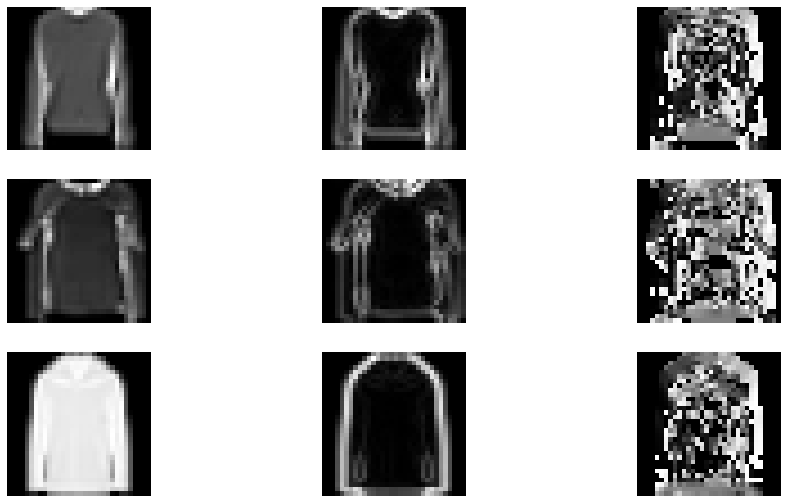

In [20]:
pullover = cv2.imread('Pullover/000.png',0)
pullover = cv2.resize(pullover,(32,32))
shirt = cv2.imread('Shirt/000.png',0)
shirt = cv2.resize(shirt,(32,32))
coat = cv2.imread('Coat/000.png',0)
coat = cv2.resize(coat,(32,32))
gradient_pullover = findGradient(pullover)
gradient_shirt = findGradient(shirt)
gradient_coat = findGradient(coat)
fig = plt.figure(figsize=(16, 9))
fig.add_subplot(3, 3, 1)
plt.imshow(pullover,cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 2)
plt.imshow(gradient_pullover[0],cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 3)
plt.imshow(gradient_pullover[1],cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 4)
plt.imshow(shirt,cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 5)
plt.imshow(gradient_shirt[0],cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 6)
plt.imshow(gradient_shirt[1],cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 7)
plt.imshow(coat,cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 8)
plt.imshow(gradient_coat[0],cmap='gray')
plt.axis('off')
fig.add_subplot(3, 3, 9)
plt.imshow(gradient_coat[1],cmap='gray')
plt.axis('off')

Essas imagens, mesmo sendo de 3 classes diferentes, ainda são classificadas como parte de uma mesma classe pelo método. Isso ocorre porque temos que, mesmo as classes sendo diferentes, os seus gradientes apresentam um certo grau de similaridade, mesmo que estejam permutados pela imagem, o que faz com que possa haver uma confusão durante a diferenciação dessas classes no método.

## Parte 2: Uso de Outros Métodos
A segunda parte do trabalho consiste em utilizar outros métodos e comparar os resultados obtidos com os que foram encontrandos durante a execução do HOG.

Os métodos escolhidos foram o ORB e o SIFT, sendo ambos de borda, e o BRIEF, que é um método de textura.

In [21]:
orb = cv2.ORB_create(fastThreshold=0, edgeThreshold=0)
sift = cv2.SIFT_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

### Definição dos KeyPoints
Tanto o SIFT quando o ORB são métodos que dependem da detecção de pontos de interesse da imagem para funcionarem, retornando uma matriz, em que cada linha representa um vetor de features do entorno de um dos pontos de interesse. Desta forma, de forma que os pontos de interesse considerados fossem os mesmos, esses foram definidos como sendo os pontos da forma (4k,4l). Assim, temos que, independente da imagem, os métodos não terão variação de acordo com a imagem, e os vetores de características de cada um dos pontos de interesse representa a mesma região independente da imagem.

In [22]:
kp = []
for i in range(0,32,4):
    for j in range(0,32,4):
        kp += [cv2.KeyPoint(i,j,1)]

O BRIEF no entanto, não depende da detecção de pontos de interesse efetivamente, mas do relacionamento entre diferentes pontos da imagem, e, como mostrado no artigo que deu origem a esse método, uma distribuição uniforme não é uma escolha ruim. Desta forma, o seguinte padrão de comparações é gerado para ser passado para a função, sendo este composto por 300 pontos.

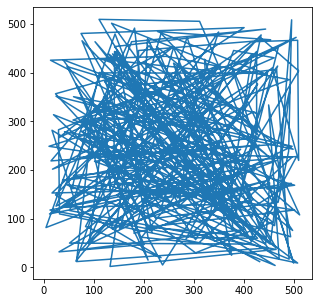

In [23]:
kp_brief = []
k_plot = np.zeros((2,300))
for i in range(300):
    j = random.randint(0,512**2)
    kp_brief += [cv2.KeyPoint(j//512,int(j%512),1)]
    k_plot[0,i] = j//512
    k_plot[1,i] = j%512
    
plt.figure(figsize=(5,5))
plt.plot(k_plot[0,:],k_plot[1,:],'-')
plt.show()

### Processamento das Imagens
As seguintes células são responsáveis por abrir cada uma das imagens e executar os 3 métodos sobre elas, obtendo assim seus respectivos vetores de features.

Um fator que se deve ser atentado, é que a imagem que é passada para o método BRIEF é re-escalada para o tamanho 512x512 e o filtro gaussiano é passado sobre ela, de modo que o método apresente melhores resultados.

In [24]:
img = cv2.imread('Sandal/000.png', 0)
orb_result = orb.compute(img,kp)[1].reshape(1,2048)
sift_result = sift.compute(img,kp)[1].reshape(1,8192)
img = cv2.resize(img, (512,512))
img = cv2.GaussianBlur(img,(9,9),3)
b_kp, b_des = brief.compute(img,kp_brief)
brief_result = b_des.reshape(1,b_des.size)
for i in range(1,100):
    i = str(i).zfill(3)
    img = cv2.imread('Sandal/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [25]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Pullover/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [26]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Trouser/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [27]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Ankle Boot/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [28]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Bag/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [29]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Coat/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [30]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Dress/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [31]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Shirt/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [32]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('Sneaker/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

In [33]:
for i in range(100):
    i = str(i).zfill(3)
    img = cv2.imread('T-shirt/'+i+'.png', 0)
    orb_result = np.concatenate((orb_result, orb.compute(img,kp)[1].reshape(1,2048)), axis=0)
    sift_result = np.concatenate((sift_result, sift.compute(img,kp)[1].reshape(1,8192)), axis=0)
    img = cv2.resize(img, (512,512))
    img = cv2.GaussianBlur(img,(9,9),3)
    b_kp, b_des = brief.compute(img,kp_brief)
    brief_result = np.concatenate((brief_result, b_des.reshape(1,b_des.size)),axis=0)

### Redução de Dimensionalidade
Após o fim da extração dos vetores de features, estes tem sua dimensionalidade reduzida através do método TSNE.

In [34]:
orb_result = TSNE().fit_transform(orb_result)
sift_result = TSNE().fit_transform(sift_result)
brief_result = TSNE().fit_transform(brief_result)

/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jorge/.local/lib/python3.8/site-packages/sklearn/manifo

## Plotagem dos Resultados para o ORB

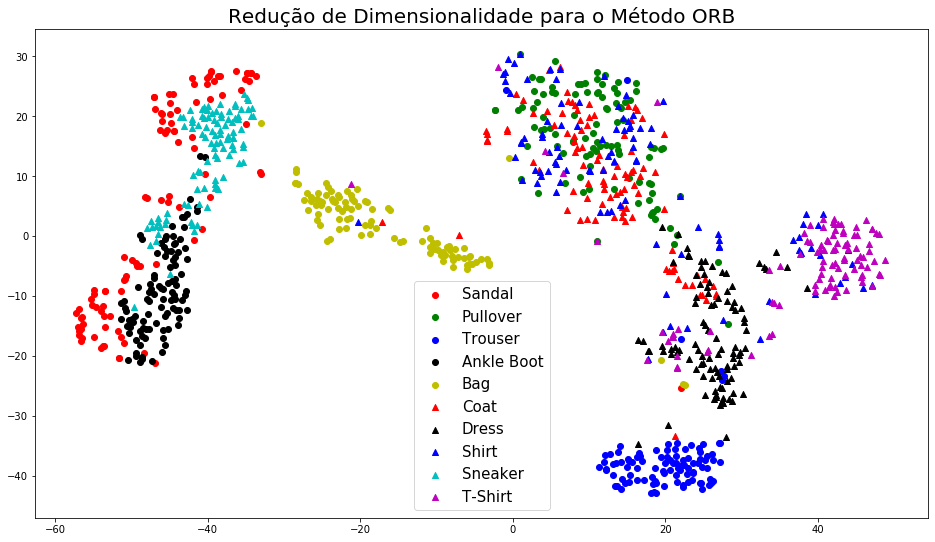

In [35]:
plt.figure(figsize=(16,9))
plt.scatter(x=orb_result[:100,0],y=orb_result[:100,1],color='r',label='Sandal')
plt.scatter(x=orb_result[100:200,0],y=orb_result[100:200,1],color='g',label='Pullover')
plt.scatter(x=orb_result[200:300,0],y=orb_result[200:300,1],color='b',label='Trouser')
plt.scatter(x=orb_result[300:400,0],y=orb_result[300:400,1],color='k',label='Ankle Boot')
plt.scatter(x=orb_result[400:500,0],y=orb_result[400:500,1],color='y',label='Bag')
plt.scatter(x=orb_result[500:600,0],y=orb_result[500:600,1],color='r',marker='^',label='Coat')
plt.scatter(x=orb_result[600:700,0],y=orb_result[600:700,1],color='k',marker='^',label='Dress')
plt.scatter(x=orb_result[700:800,0],y=orb_result[700:800,1],color='b',marker='^',label='Shirt')
plt.scatter(x=orb_result[800:900,0],y=orb_result[800:900,1],color='c',marker='^',label='Sneaker')
plt.scatter(x=orb_result[900:,0],y=orb_result[900:,1],color='m',marker='^',label='T-Shirt')
plt.legend(prop={'size': 15})
plt.title("Redução de Dimensionalidade para o Método ORB", fontdict={'fontsize': 20})
plt.show()

### Plotagem dos Resultados para o SIFT

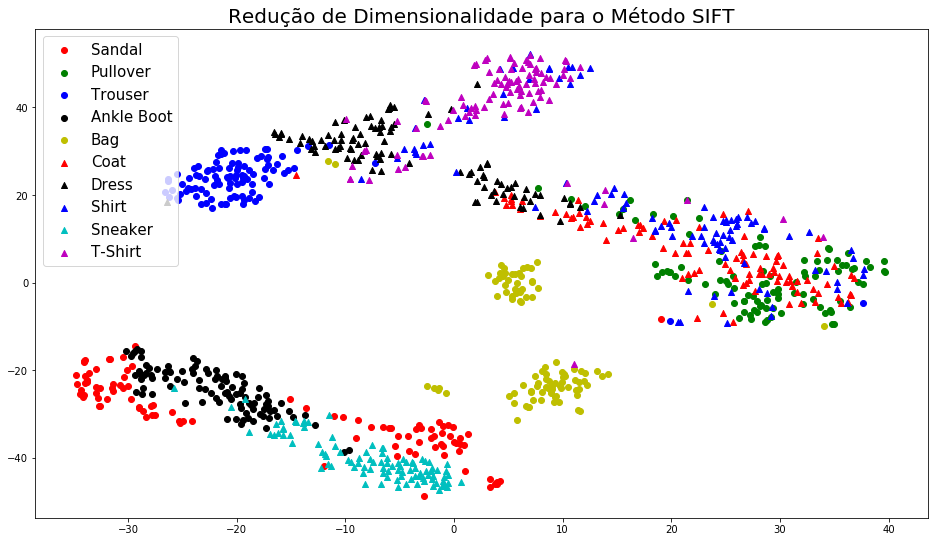

In [36]:
plt.figure(figsize=(16,9))
plt.scatter(x=sift_result[:100,0],y=sift_result[:100,1],color='r',label='Sandal')
plt.scatter(x=sift_result[100:200,0],y=sift_result[100:200,1],color='g',label='Pullover')
plt.scatter(x=sift_result[200:300,0],y=sift_result[200:300,1],color='b',label='Trouser')
plt.scatter(x=sift_result[300:400,0],y=sift_result[300:400,1],color='k',label='Ankle Boot')
plt.scatter(x=sift_result[400:500,0],y=sift_result[400:500,1],color='y',label='Bag')
plt.scatter(x=sift_result[500:600,0],y=sift_result[500:600,1],color='r',marker='^',label='Coat')
plt.scatter(x=sift_result[600:700,0],y=sift_result[600:700,1],color='k',marker='^',label='Dress')
plt.scatter(x=sift_result[700:800,0],y=sift_result[700:800,1],color='b',marker='^',label='Shirt')
plt.scatter(x=sift_result[800:900,0],y=sift_result[800:900,1],color='c',marker='^',label='Sneaker')
plt.scatter(x=sift_result[900:,0],y=sift_result[900:,1],color='m',marker='^',label='T-Shirt')
plt.legend(prop={'size': 15})
plt.title("Redução de Dimensionalidade para o Método SIFT", fontdict={'fontsize': 20})
plt.show()

### Plotagem dos Resultados para o BRIEF

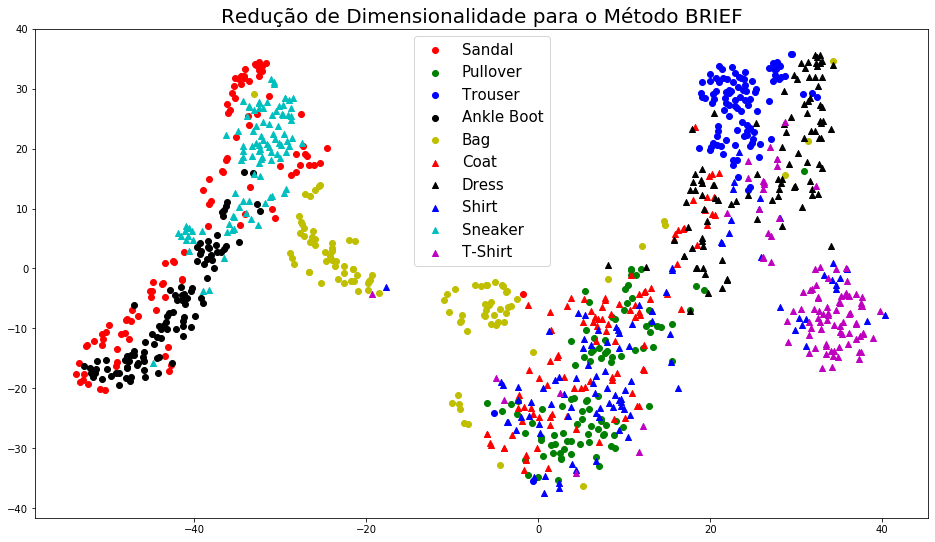

In [37]:
plt.figure(figsize=(16,9))
plt.scatter(x=brief_result[:100,0],y=brief_result[:100,1],color='r',label='Sandal')
plt.scatter(x=brief_result[100:200,0],y=brief_result[100:200,1],color='g',label='Pullover')
plt.scatter(x=brief_result[200:300,0],y=brief_result[200:300,1],color='b',label='Trouser')
plt.scatter(x=brief_result[300:400,0],y=brief_result[300:400,1],color='k',label='Ankle Boot')
plt.scatter(x=brief_result[400:500,0],y=brief_result[400:500,1],color='y',label='Bag')
plt.scatter(x=brief_result[500:600,0],y=brief_result[500:600,1],color='r',marker='^',label='Coat')
plt.scatter(x=brief_result[600:700,0],y=brief_result[600:700,1],color='k',marker='^',label='Dress')
plt.scatter(x=brief_result[700:800,0],y=brief_result[700:800,1],color='b',marker='^',label='Shirt')
plt.scatter(x=brief_result[800:900,0],y=brief_result[800:900,1],color='c',marker='^',label='Sneaker')
plt.scatter(x=brief_result[900:,0],y=brief_result[900:,1],color='m',marker='^',label='T-Shirt')
plt.legend(prop={'size': 15})
plt.title("Redução de Dimensionalidade para o Método BRIEF", fontdict={'fontsize': 20})
plt.show()

## Conclusão:
Tanto o SIFT quanto o ORB apresentaram resultados muito semelhantes ao do HOG, sendo os resultados do ORB levemente superiores aos dos outros dois, com um potencial maior de separeação em grupos do que os outros 2 métodos. Porém, temos que os problemas do HOG continuam existindo nesses 2 métodos, uma vez que trabalham com o gradiente de forma muito similar.

Enquanto isso, o BRIEF não apresentou bons resultados, sendo o pior dos 4 métodos mostrados neste trabalho. Isso se deve ao fato de ele ser baseado em texturas. Enquanto os métodos baseados em bordas eram capazes de, minimamente, separar classes que tem silhuetas parecidas, isso não ocorre no BRIEF, que é imcapaz de distinguir os calçados entre si, assim como Pullover, Coat, Trouser e Dress.

Assim, tendo em vista que foram usadas versões adaptadas tanto do SIFT quanto do ORB, concluir que estes são os melhores entre os métodos mostrados, podendo esperar resultados ainda melhores se usarmos esses métodos da maneira como foram criados para serem usados.